In [1]:
import pandas as pd
import glob
from pathlib import Path
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from lightgbm import LGBMClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
files = glob.glob('/content/drive/MyDrive/best_sellers_2000/amz_data_*_train.csv')

dfs = []
for f in files:
    dfs.append(pd.read_csv(f, parse_dates=['time']))
df = pd.concat(dfs, ignore_index=True)

In [4]:
df.head()

,time,sellerId,hold_buybox,price,price_rank,price_diff,price_ratio,isFBA,isAmazon,condition,...,avg_self_price_14d,avg_price_rank_14d,avg_asin_price_14d,avg_self_price_30d,avg_price_rank_30d,avg_asin_price_30d,avg_self_price_60d,avg_price_rank_60d,avg_asin_price_60d,asin
0,2023-05-07 10:06:00,A2L77EE7U53NWQ,0,33.24,1.0,0.0,1.0,True,False,2,...,33.24,1.0,34.115,33.240,1.0,34.1150,33.2400,1.0,34.11500,B09SBT92JH
1,2023-05-26 13:40:00,A2L77EE7U53NWQ,0,31.25,1.0,0.0,1.0,True,False,2,...,31.25,1.0,33.120,32.245,1.0,33.6175,32.2450,1.0,33.61750,B09SBT92JH
2,2023-06-06 23:14:00,A2L77EE7U53NWQ,0,30.25,1.0,0.0,1.0,True,False,2,...,30.75,1.0,32.870,30.750,1.0,32.8700,31.5800,1.0,33.28500,B09SBT92JH
3,2023-06-08 19:20:00,A2L77EE7U53NWQ,0,29.25,1.0,0.0,1.0,True,False,2,...,30.25,1.0,32.620,30.250,1.0,32.6200,30.9975,1.0,32.99375,B09SBT92JH
4,2023-06-19 08:36:00,A2L77EE7U53NWQ,0,28.25,1.0,0.0,1.0,True,False,2,...,29.25,1.0,32.120,29.750,1.0,32.3700,30.4480,1.0,32.71900,B09SBT92JH


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431025 entries, 0 to 1431024
Data columns (total 22 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   time                1431025 non-null  datetime64[ns]
 1   sellerId            1431025 non-null  object        
 2   hold_buybox         1431025 non-null  int64         
 3   price               1431025 non-null  float64       
 4   price_rank          1431025 non-null  float64       
 5   price_diff          1431025 non-null  float64       
 6   price_ratio         1431025 non-null  float64       
 7   isFBA               1431025 non-null  bool          
 8   isAmazon            1431025 non-null  bool          
 9   condition           1431025 non-null  int64         
 10  num_competitors     1431025 non-null  int64         
 11  sales_rank          1431011 non-null  float64       
 12  avg_self_price_14d  1431025 non-null  float64       
 13  avg_price_ra

In [6]:
# Missing values
print(df.isna().sum().loc[lambda s: s>0])

# balance check
print(df['hold_buybox'].value_counts(normalize=True))

# Time range
print("Time span:", df['time'].min(), "→", df['time'].max())

# Unique counts
print("#ASINs:", df['asin'].nunique())
print("#Sellers:", df['sellerId'].nunique())

# Drop Duplicates
df = df.dropna(subset=['sales_rank'])

sales_rank    14
dtype: int64
hold_buybox
0    0.980334
1    0.019666
Name: proportion, dtype: float64
Time span: 2017-02-16 14:20:00 → 2024-12-06 19:08:00
#ASINs: 35
#Sellers: 450


In [7]:
# Adding time-based features
df['year']    = df['time'].dt.year.astype('uint16')
df['month']   = df['time'].dt.month.astype('uint8')
df['day']     = df['time'].dt.day.astype('uint8')
df['hour']    = df['time'].dt.hour.astype('uint8')
df['weekday'] = df['time'].dt.weekday.astype('uint8')  # Monday=0

In [8]:
# One-hot code for conditions
cond_dummies = pd.get_dummies(df['condition'], prefix='cond', dtype='uint8')
df = pd.concat([df, cond_dummies], axis=1)

df = df.drop(columns=['condition'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1431011 entries, 0 to 1431024
Data columns (total 33 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   time                1431011 non-null  datetime64[ns]
 1   sellerId            1431011 non-null  object        
 2   hold_buybox         1431011 non-null  int64         
 3   price               1431011 non-null  float64       
 4   price_rank          1431011 non-null  float64       
 5   price_diff          1431011 non-null  float64       
 6   price_ratio         1431011 non-null  float64       
 7   isFBA               1431011 non-null  bool          
 8   isAmazon            1431011 non-null  bool          
 9   num_competitors     1431011 non-null  int64         
 10  sales_rank          1431011 non-null  float64       
 11  avg_self_price_14d  1431011 non-null  float64       
 12  avg_price_rank_14d  1431011 non-null  float64       
 13  avg_asin_price_14

## Feature selection

In [10]:
features = [
    # raw
    'price','price_rank','price_diff','price_ratio',
    'num_competitors','sales_rank',
    # rolling
    'avg_self_price_14d','avg_price_rank_14d','avg_asin_price_14d',
    'avg_self_price_30d','avg_price_rank_30d','avg_asin_price_30d',
    'avg_self_price_60d','avg_price_rank_60d','avg_asin_price_60d',
    # time
    'year','month','day','hour','weekday',
    # flags
    'isFBA','isAmazon',
    # condition one-hots
    'cond_1','cond_2','cond_3','cond_4','cond_5',
    'cond_7',
    #'sellerId','asin'
]

## Benchmark

In [11]:
df['num_competitors'] = (
    df
    .groupby(['asin','time'])['sellerId']
    .transform('nunique')
)

# baseline：最低价预测赢
baseline_pred = (df['price_rank'] == 1).astype(int)

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = df['hold_buybox']
y_pred = baseline_pred

prec = precision_score(y_true, y_pred, pos_label=1)
rec  = recall_score(y_true, y_pred, pos_label=1)
f1   = f1_score(y_true, y_pred, pos_label=1)

print(f"Baseline 精确率 (precision): {prec:.3%}")
print(f"Baseline 召回率 (recall)    : {rec:.3%}")
print(f"Baseline F1               : {f1:.3%}")

Baseline 精确率 (precision): 34.085%
Baseline 召回率 (recall)    : 35.444%
Baseline F1               : 34.751%


## Train-test split

In [15]:
# 1. Sort by time and define split points
df = df.sort_values('time')
train_end = df['time'].quantile(0.70)
val_end   = df['time'].quantile(0.85)

train = df[df['time'] <= train_end]
val   = df[(df['time'] > train_end) & (df['time'] <= val_end)]
test  = df[df['time'] > val_end]

In [16]:
X_train, y_train = train[features], train['hold_buybox']
X_val,   y_val   = val[features],   val['hold_buybox']
X_test,  y_test  = test[features],  test['hold_buybox']

In [17]:
for name, split in [('train', train), ('val', val), ('test', test)]:
    counts = split['hold_buybox'].value_counts().sort_index()
    zeros = counts.get(0, 0)
    ones  = counts.get(1, 0)
    total = len(split)
    print(f"{name.upper():5s}: 0 → {zeros} ({zeros/total:.1%}),  1 → {ones} ({ones/total:.1%})")

TRAIN: 0 → 980361 (97.9%),  1 → 21385 (2.1%)
VAL  : 0 → 211212 (98.4%),  1 → 3483 (1.6%)
TEST : 0 → 211309 (98.5%),  1 → 3261 (1.5%)


## Modeling

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve,confusion_matrix

In [19]:
models = {
    "RF (balanced)": RandomForestClassifier(
        n_estimators=100, max_depth=10,
        class_weight="balanced", n_jobs=-1, random_state=42),
    "HistGB": HistGradientBoostingClassifier(
        max_iter=200, random_state=42),
    "BalancedRF": BalancedRandomForestClassifier(
        n_estimators=100, sampling_strategy="auto", random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=6,
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        use_label_encoder=False, eval_metric="auc",
        n_jobs=-1, random_state=42),
}

for name, clf in models.items():
    print(f"\n=== {name} ===")
    # pipeline to impute any NaNs
    pipe = make_pipeline(SimpleImputer(strategy="median"), clf)
    pipe.fit(X_train[features], y_train)

    # Validation metrics
    probs = pipe.predict_proba(X_val[features])[:,1]
    preds = (probs >= 0.5).astype(int)
    print("Val ROC-AUC:", roc_auc_score(y_val, probs))
    print(classification_report(y_val, preds, digits=3))

    # Tune threshold for better precision/recall
    prec, rec, thr = precision_recall_curve(y_val, probs)
    for target_prec in [0.2, 0.5, 0.8]:
        idx = np.argmax(prec >= target_prec)
        print(f"→ thresh={thr[idx]:.2f} gives P={prec[idx]:.2f}, R={rec[idx]:.2f}")



=== RF (balanced) ===
Val ROC-AUC: 0.9725952949867032
              precision    recall  f1-score   support

           0      0.995     0.996     0.996    211212
           1      0.753     0.712     0.732      3483

    accuracy                          0.992    214695
   macro avg      0.874     0.854     0.864    214695
weighted avg      0.991     0.992     0.991    214695

→ thresh=0.27 gives P=0.20, R=0.81
→ thresh=0.41 gives P=0.50, R=0.75
→ thresh=0.53 gives P=0.80, R=0.70

=== HistGB ===
Val ROC-AUC: 0.9687517224530625
              precision    recall  f1-score   support

           0      0.995     0.997     0.996    211212
           1      0.813     0.689     0.746      3483

    accuracy                          0.992    214695
   macro avg      0.904     0.843     0.871    214695
weighted avg      0.992     0.992     0.992    214695

→ thresh=0.02 gives P=0.20, R=0.84
→ thresh=0.21 gives P=0.50, R=0.71
→ thresh=0.42 gives P=0.81, R=0.69

=== BalancedRF ===
Val ROC-AUC: 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:34:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Val ROC-AUC: 0.9622447219552343
              precision    recall  f1-score   support

           0      0.995     0.996     0.996    211212
           1      0.762     0.712     0.736      3483

    accuracy                          0.992    214695
   macro avg      0.879     0.854     0.866    214695
weighted avg      0.991     0.992     0.992    214695

→ thresh=0.03 gives P=0.20, R=0.83
→ thresh=0.17 gives P=0.50, R=0.77
→ thresh=0.62 gives P=0.80, R=0.69


In [20]:
# Balanced RF Pipe
pipe_rf = models["RF (balanced)"]

# 1. Tune threshold on val
probs_val = pipe_rf.predict_proba(X_val[features])[:,1]
prec, rec, thr = precision_recall_curve(y_val, probs_val)

# Pick threshold for ≥ 0.80 precision
target_precision = 0.80
idx = np.argmax(prec >= target_precision)
rf_threshold = thr[idx]
print(f"RF threshold for ≥{target_precision:.2f} precision: {rf_threshold:.3f}")
print(f"Precision={prec[idx]:.3f}, Recall={rec[idx]:.3f}\n")

# 2. Evaluate on TEST
probs_test = pipe_rf.predict_proba(X_test[features])[:,1]
preds_test = (probs_test >= rf_threshold).astype(int)

print("=== RF (balanced) Final Test Performance ===")
print(f"ROC AUC: {roc_auc_score(y_test, probs_test):.3f}\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, preds_test), "\n")
print("Classification Report:")
print(classification_report(y_test, preds_test, digits=3))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


RF threshold for ≥0.80 precision: 0.526
Precision=0.800, Recall=0.702



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


=== RF (balanced) Final Test Performance ===
ROC AUC: 0.964

Confusion Matrix:
[[210952    357]
 [   999   2262]] 

Classification Report:
              precision    recall  f1-score   support

           0      0.995     0.998     0.997    211309
           1      0.864     0.694     0.769      3261

    accuracy                          0.994    214570
   macro avg      0.929     0.846     0.883    214570
weighted avg      0.993     0.994     0.993    214570



In [21]:
# XGboost Pipe
pipe_xg = models["XGBoost"]

# 1.Tune threshold on val
probs_val = pipe_xg.predict_proba(X_val[features])[:,1]

# 2. precision/recall curve
prec, rec, thr = precision_recall_curve(y_val, probs_val)

# pick the threshold that first achieves >= 0.8 precision
target_precision = 0.80
idx = np.argmax(prec >= target_precision)
tuned_threshold = thr[idx]
print(f"Chosen threshold for ≥{target_precision:.2f} precision: {tuned_threshold:.3f}")
print(f"Precision={prec[idx]:.3f}, Recall={rec[idx]:.3f} at that threshold\n")

# 3. Evaluate on test set
probs_test = pipe_xg.predict_proba(X_test[features])[:,1]
preds_test = (probs_test >= tuned_threshold).astype(int)

print("=== Final Test Performance ===")
print(f"ROC AUC: {roc_auc_score(y_test, probs_test):.3f}\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, preds_test), "\n")
print("Classification Report:")
print(classification_report(y_test, preds_test, digits=3))

Chosen threshold for ≥0.80 precision: 0.624
Precision=0.800, Recall=0.693 at that threshold

=== Final Test Performance ===
ROC AUC: 0.946

Confusion Matrix:
[[211046    263]
 [   949   2312]] 

Classification Report:
              precision    recall  f1-score   support

           0      0.996     0.999     0.997    211309
           1      0.898     0.709     0.792      3261

    accuracy                          0.994    214570
   macro avg      0.947     0.854     0.895    214570
weighted avg      0.994     0.994     0.994    214570



In [23]:
estimators = models

imps = {}
for name, obj in estimators.items():
    if hasattr(obj, "named_steps"):
        step_names = list(obj.named_steps.keys())
        clf = obj.named_steps[step_names[-1]]
    else:
        clf = obj

    # importances
    if hasattr(clf, "feature_importances_"):
        imp = pd.Series(clf.feature_importances_, index=features)
        imp = imp.sort_values(ascending=False)
        imp.name = "importance"
    elif hasattr(clf, "coef_"):
        imp = pd.Series(clf.coef_[0], index=features).abs()
        imp = imp.sort_values(ascending=False)
        imp.name = "abs_coef"
    else:
        continue

    imps[name] = imp

topn = 10
df_top = (
    pd.concat([s.head(topn).rename(name) for name, s in imps.items()], axis=1)
)

print(df_top)
#display(df_top.style.background_gradient(cmap="Blues"))

                    RF (balanced)  BalancedRF   XGBoost
isAmazon                 0.226342    0.182502  0.792303
isFBA                    0.108145    0.106827  0.016234
avg_price_rank_60d       0.103587    0.084666       NaN
avg_price_rank_14d       0.077706    0.069679       NaN
avg_price_rank_30d       0.062987    0.068957       NaN
avg_self_price_30d       0.053328    0.050642       NaN
avg_self_price_14d       0.051836    0.049767       NaN
price_rank               0.049069    0.052212  0.017047
avg_self_price_60d       0.046209    0.049198       NaN
price_diff               0.041816    0.067217  0.007572
avg_asin_price_60d            NaN         NaN  0.034343
cond_5                        NaN         NaN  0.014701
num_competitors               NaN         NaN  0.014383
cond_2                        NaN         NaN  0.009995
cond_4                        NaN         NaN  0.009973
price                         NaN         NaN  0.007907


## Reduced Feature RF

In [46]:
# Reduced feature list
reduced_features = [
    "isAmazon",
    "isFBA",
    "avg_price_rank_60d",
    "avg_price_rank_14d",
    "avg_price_rank_30d",
    "avg_self_price_30d",
    "avg_self_price_14d",
    "price_rank",
    "avg_self_price_60d",
    "price_diff",
]

X_train_red = X_train[reduced_features]
X_val_red   = X_val[reduced_features]
X_test_red  = X_test[reduced_features]

In [48]:
# Retrain the RF (balanced) pipeline
pipe_red_rf = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    )
)
pipe_red_rf.fit(X_train_red, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_jobs=-1, random_state=42))])

In [50]:
# Re-tune threshold on VAL for ≥ 0.80 precision
probs_val_red = pipe_red_rf.predict_proba(X_val_red)[:,1]
prec, rec, thr = precision_recall_curve(y_val, probs_val_red)

target_precision = 0.80
idx = np.argmax(prec >= target_precision)
rf_threshold_red = thr[idx]
print(f"Threshold for ≥{target_precision:.2f} precision: {rf_threshold_red:.3f}")
print(f"Val Precision={prec[idx]:.3f}, Recall={rec[idx]:.3f}\n")

# Evaluate on TEST using that threshold
probs_test_red = pipe_red_rf.predict_proba(X_test_red)[:,1]
preds_test_red = (probs_test_red >= rf_threshold_red).astype(int)

print("=== Reduced-Feature RF Final Test Performance ===")
print(f"ROC AUC: {roc_auc_score(y_test, probs_test_red):.3f}\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, preds_test_red), "\n")
print("Classification Report:")
print(classification_report(y_test, preds_test_red, digits=3))

Threshold for ≥0.80 precision: 0.594
Val Precision=0.800, Recall=0.686

=== Reduced-Feature RF Final Test Performance ===
ROC AUC: 0.953

Confusion Matrix:
[[210912    397]
 [  1008   2253]] 

Classification Report:
              precision    recall  f1-score   support

           0      0.995     0.998     0.997    211309
           1      0.850     0.691     0.762      3261

    accuracy                          0.993    214570
   macro avg      0.923     0.845     0.879    214570
weighted avg      0.993     0.993     0.993    214570



## Saving Model

In [43]:
import joblib

joblib.dump(pipe_rf, '/content/drive/MyDrive/pipe_rf.joblib')
print("✅ Saved RF pipeline!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved RF pipeline!


In [45]:
from google.colab import files
files.download('pipe_rf.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
joblib.dump(pipe_red_rf, '/content/drive/MyDrive/pipe_red_rf.joblib')
print("✅ Saved Reduced RF pipeline!")

✅ Saved Reduced RF pipeline!


## Cross Validation

In [32]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [33]:
# 2) Define your RF (same hyper‐params as before)
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 3) Set up Stratified K-Fold on the **training** data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4) Scorers
scoring = {
    'roc_auc': 'roc_auc',
    'prec_1': make_scorer(precision_score, pos_label=1),
    'rec_1':  make_scorer(recall_score,    pos_label=1),
    'f1_1':   make_scorer(f1_score,        pos_label=1),
}

# 5) Cross-validate on TRAINING only
cv_results = cross_validate(
    rf,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# 6) Report mean ± std on train folds
for k,v in cv_results.items():
    if k.startswith('test_'):
        print(f"{k:8s}: {v.mean():.3f} ± {v.std():.3f}")

test_roc_auc: 0.990 ± 0.001
test_prec_1: 0.935 ± 0.005
test_rec_1: 0.825 ± 0.005
test_f1_1: 0.876 ± 0.003


## Some Plotting

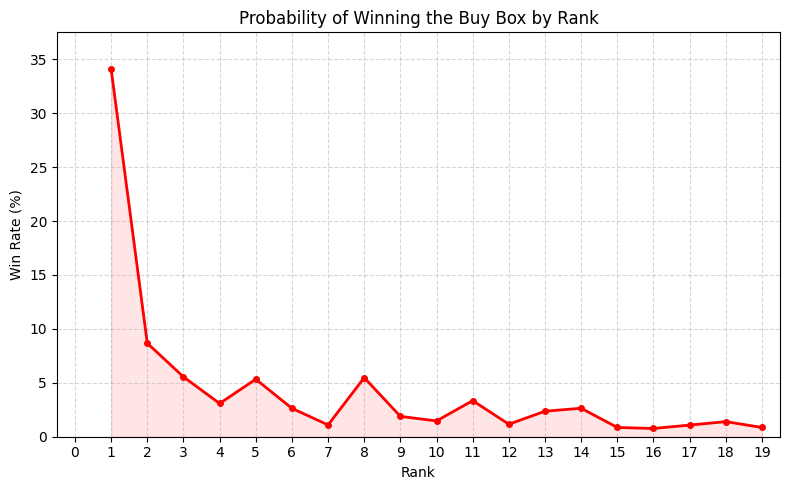

In [25]:
import matplotlib.pyplot as plt

# Compute win rate per rank
win_prob = (
    df.groupby('price_rank')['hold_buybox']
      .mean()
      .loc[0:19]      # keep only ranks 0–19
      .reset_index(name='win_rate')
)
win_prob['win_rate_pct'] = win_prob['win_rate'] * 100

plt.figure(figsize=(8, 5))
plt.plot(
    win_prob['price_rank'],
    win_prob['win_rate_pct'],
    color='red',
    linewidth=2,
    marker='o',
    markersize=4
)
plt.fill_between(
    win_prob['price_rank'],
    win_prob['win_rate_pct'],
    color='red',
    alpha=0.1
)

plt.xticks(range(0, 20, 1))
plt.xlim(-0.5, 19.5)
plt.ylim(0, win_prob['win_rate_pct'].max() * 1.1)
plt.xlabel('Rank')
plt.ylabel('Win Rate (%)')
plt.title('Probability of Winning the Buy Box by Rank')
plt.grid(which='major', linestyle='--', alpha=0.5)=
plt.tight_layout()
plt.show()


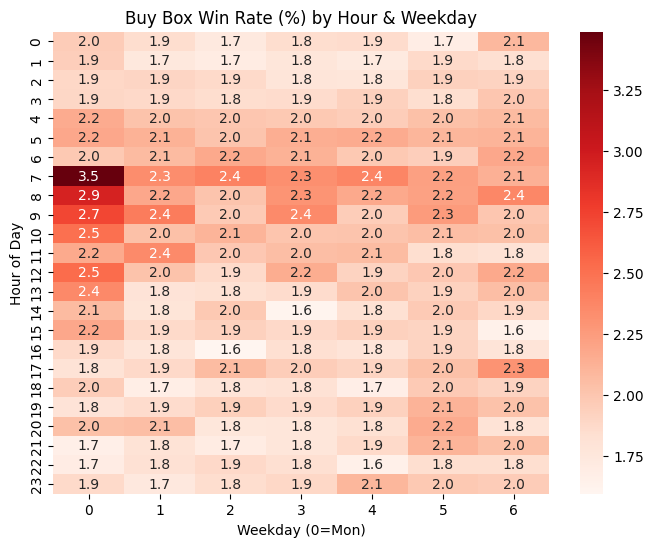

In [26]:
# extract hour and weekday
df['hour']    = df['time'].dt.hour
df['weekday'] = df['time'].dt.weekday  # 0=Mon…6=Sun

# pivot table of win‐rate
pivot = df.pivot_table(
    index='hour', columns='weekday',
    values='hold_buybox', aggfunc='mean'
) * 100

# heatmap
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Reds")
plt.xlabel("Weekday (0=Mon)")
plt.ylabel("Hour of Day")
plt.title("Buy Box Win Rate (%) by Hour & Weekday")
plt.show()


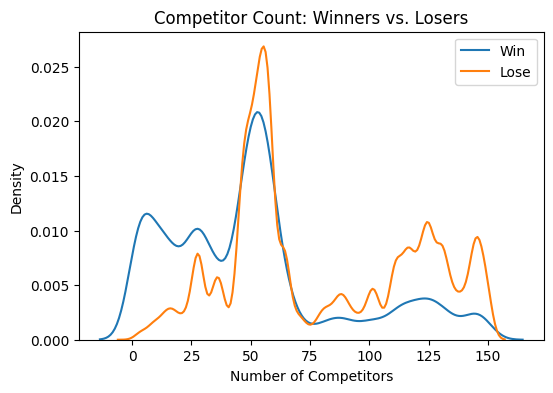

In [29]:
plt.figure(figsize=(6,4))
sns.kdeplot(df.loc[df.hold_buybox==1,'num_competitors'], label='Win')
sns.kdeplot(df.loc[df.hold_buybox==0,'num_competitors'], label='Lose')
plt.xlabel("Number of Competitors")
plt.ylabel("Density")
plt.title("Competitor Count: Winners vs. Losers")
plt.legend()
plt.show()


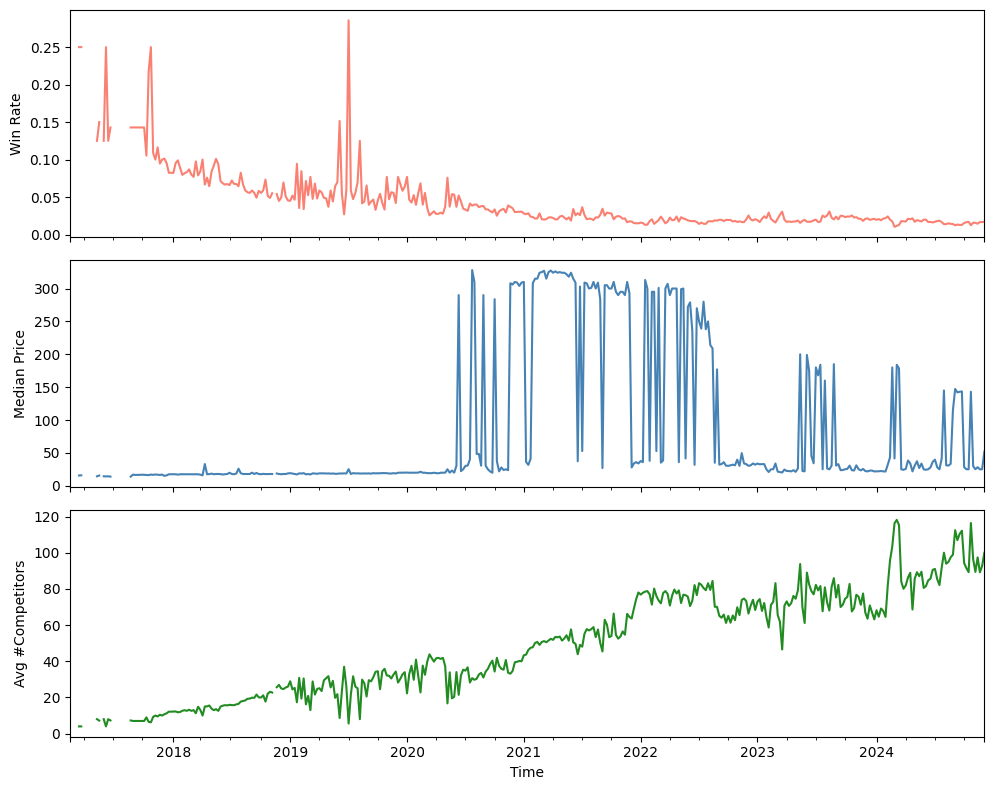

In [31]:
ts = df.set_index('time').resample('W').agg({
  'hold_buybox':'mean',
  'price':'median',
  'num_competitors':'mean'
})
fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ts['hold_buybox'].plot(ax=ax[0], color='salmon')
ax[0].set_ylabel("Win Rate")
ts['price'].plot(ax=ax[1], color='steelblue')
ax[1].set_ylabel("Median Price")
ts['num_competitors'].plot(ax=ax[2], color='forestgreen')
ax[2].set_ylabel("Avg #Competitors")
plt.xlabel("Time")
plt.tight_layout()
plt.show()


## Remove is Amazon

In [22]:
features_no_az = [f for f in features if f != 'isAmazon']

In [23]:
# 2) Prepare your train/val/test splits exactly as before,
#    but now use features_no_az instead of features_with_lags:
X_train_n = X_train[features_no_az]
X_test_n  = X_test[features_no_az]
y_train_n = y_train
y_test_n  = y_test

In [24]:
# 3) Re-instantiate your models
models = {
    "RF (balanced)": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,
        max_depth=6,
        scale_pos_weight=(y_train_n==0).sum()/(y_train_n==1).sum(),
        use_label_encoder=False,
        eval_metric='auc',
        n_jobs=-1,
        random_state=42
    )
}

# 4) Fit & evaluate
for name, clf in models.items():
    clf.fit(X_train_n, y_train_n)
    probs = clf.predict_proba(X_test_n)[:,1]
    preds = (probs >= 0.5).astype(int)   # or re-tune your threshold here
    print(f"=== {name} ===")
    print(f"ROC AUC: {roc_auc_score(y_test_n, probs):.3f}")
    print(classification_report(y_test_n, preds, digits=3))
    print()

=== RF (balanced) ===
ROC AUC: 0.956
              precision    recall  f1-score   support

           0      0.995     0.988     0.992    211309
           1      0.480     0.699     0.569      3261

    accuracy                          0.984    214570
   macro avg      0.738     0.843     0.781    214570
weighted avg      0.987     0.984     0.985    214570




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:16:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost ===
ROC AUC: 0.946
              precision    recall  f1-score   support

           0      0.995     0.994     0.994    211309
           1      0.619     0.666     0.641      3261

    accuracy                          0.989    214570
   macro avg      0.807     0.830     0.818    214570
weighted avg      0.989     0.989     0.989    214570




In [26]:
for name, clf in models.items():
    fi = pd.Series(
        clf.feature_importances_,
        index=features_no_az,
        name="importance"
    ).sort_values(ascending=False)
    print(f"=== {name} Feature Importances ===")
    print(fi.head(10))
    print("\n" + "-"*60 + "\n")


=== RF (balanced) Feature Importances ===
isFBA                 0.186867
avg_price_rank_60d    0.117139
avg_price_rank_14d    0.086879
price_diff            0.076629
avg_self_price_30d    0.076110
avg_price_rank_30d    0.067958
avg_self_price_14d    0.064866
price_rank            0.054331
num_competitors       0.049409
avg_self_price_60d    0.042533
Name: importance, dtype: float64

------------------------------------------------------------

=== XGBoost Feature Importances ===
isFBA                 0.483861
price_diff            0.067151
num_competitors       0.042515
year                  0.041181
avg_asin_price_14d    0.039678
price_rank            0.036563
avg_self_price_14d    0.035244
price_ratio           0.031894
avg_self_price_60d    0.025937
cond_5                0.024620
Name: importance, dtype: float32

------------------------------------------------------------



## RF + Lag Features

In [32]:
new_df = df.copy()

In [33]:
new_df = new_df.sort_values(['asin','sellerId','time']).reset_index(drop=True)

In [34]:
to_lag = ['price_diff', 'price_ratio', 'hold_buybox']

for col in to_lag:
    new_df[f'{col}_lag1'] = (
        new_df
        .groupby(['asin','sellerId'])[col]
        .shift(1)
    )

In [35]:
# Fill NaNs
new_df[['price_diff_lag1','price_ratio_lag1','hold_buybox_lag1']] = \
    new_df[['price_diff_lag1','price_ratio_lag1','hold_buybox_lag1']].fillna(0)

In [36]:
new_df[['price_diff','price_diff_lag1',
        'price_ratio','price_ratio_lag1',
        'hold_buybox','hold_buybox_lag1']].head(5)

,price_diff,price_diff_lag1,price_ratio,price_ratio_lag1,hold_buybox,hold_buybox_lag1
0,2.77,0.00,1.246881,0.000000,1,0.0
1,2.77,2.77,1.246881,1.246881,0,1.0
2,2.77,2.77,1.246881,1.246881,0,0.0
3,2.77,2.77,1.246881,1.246881,0,0.0
4,2.77,2.77,1.246881,1.246881,0,0.0


In [37]:
lag_features = ['price_diff_lag1','price_ratio_lag1','hold_buybox_lag1']
features_with_lags = features + lag_features

In [38]:
# 2) Re-split data by time
df_sorted_new = new_df.sort_values('time')
train_end_new = df_sorted_new['time'].quantile(0.70)
val_end_new   = df_sorted_new['time'].quantile(0.85)

train_new = df_sorted_new[df_sorted_new['time'] <= train_end_new]
val_new   = df_sorted_new[(df_sorted_new['time'] > train_end_new) & (df_sorted_new['time'] <= val_end_new)]
test_new  = df_sorted_new[df_sorted_new['time'] > val_end_new]

X_train_new, y_train_new = train_new[features_with_lags], train_new['hold_buybox']
X_val_new,   y_val_new   = val_new[features_with_lags],   val_new['hold_buybox']
X_test_new,  y_test_new  = test_new[features_with_lags],  test_new['hold_buybox']

In [39]:
# 3) Fit RandomForest (balanced)
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train_new, y_train_new)

# 4) Evaluate on test set
probs_test_new = clf.predict_proba(X_test_new)[:,1]
preds_test_new = clf.predict(X_test_new)


print("=== Model Performance with Lag Features ===")
print(f"ROC AUC: {roc_auc_score(y_test_new, probs_test_new):.3f}\n")
print(classification_report(y_test_new, preds_test_new, digits=3))

=== Model Performance with Lag Features ===
ROC AUC: 0.979

              precision    recall  f1-score   support

           0      0.997     0.997     0.997    211309
           1      0.824     0.795     0.809      3261

    accuracy                          0.994    214570
   macro avg      0.911     0.896     0.903    214570
weighted avg      0.994     0.994     0.994    214570



In [40]:
print("Confusion Matrix:")
print(confusion_matrix(y_test_new, preds_test_new), "\n")

Confusion Matrix:
[[210756    553]
 [   668   2593]] 



In [41]:
feat_imp = pd.Series(
    clf.feature_importances_,
    index=features_with_lags,
    name='importance'
).sort_values(ascending=False)

imps_df = feat_imp.reset_index().rename(columns={'index':'feature'})

#tools.display_dataframe_to_user("Feature Importances with Lag Features", imps_df)
imps_df.head(10)

,feature,importance
0,hold_buybox_lag1,0.295650
1,isAmazon,0.159678
2,avg_price_rank_60d,0.073079
3,isFBA,0.070392
4,avg_price_rank_30d,0.055497
5,avg_price_rank_14d,0.048368
6,avg_self_price_14d,0.038707
7,price_diff,0.034226
8,avg_self_price_60d,0.029758
9,price_diff_lag1,0.024898


## Time Series

count    1.431010e+06
mean     1.720863e+02
std      5.393274e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.522400e+06
Name: delta_s, dtype: float64


<ipython-input-31-9fd089d80d97>:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  counts = df.set_index('time').resample('1H').size()


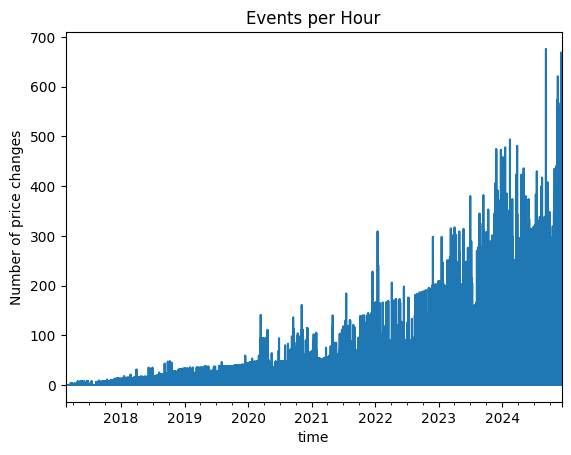

In [31]:
import matplotlib.pyplot as plt

# 1) Parse your time column and sort
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

# 2) Compute inter‐arrival (delta) in seconds
df['delta_s'] = df['time'].diff().dt.total_seconds()

# 3) Quick summary of the gaps
print(df['delta_s'].describe())

# 6) Event rate over a regular grid (e.g. hourly)
counts = df.set_index('time').resample('1H').size()
plt.figure()
counts.plot()
plt.ylabel('Number of price changes')
plt.title('Events per Hour')
plt.show()


In [28]:
pct_zero = (df['delta_s']==0).mean() * 100
print(f"{pct_zero:.1f}% of all deltas are exactly 0 s")

98.1% of all deltas are exactly 0 s


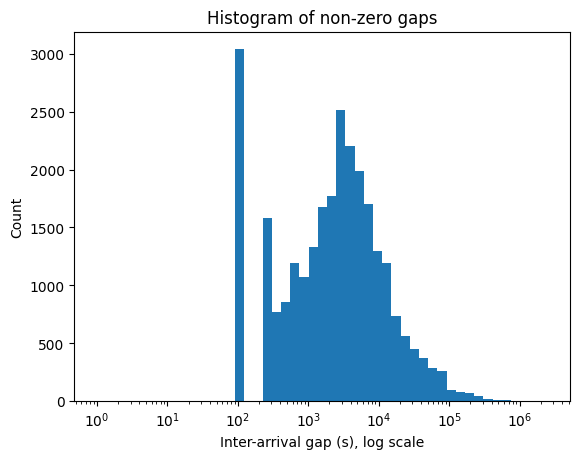

In [29]:
import numpy as np
nonzero = df.loc[df['delta_s']>0, 'delta_s']
plt.figure()
plt.hist(nonzero, bins=np.logspace(0, np.log10(nonzero.max()), 50))
plt.xscale('log')
plt.xlabel('Inter-arrival gap (s), log scale')
plt.ylabel('Count')
plt.title('Histogram of non-zero gaps')
plt.show()
